In [1]:
import sys
from pathlib import Path
curr_path = str(Path().absolute())
parent_path = str(Path().absolute().parent)
sys.path.append(parent_path) # add current terminal path to sys.path

In [2]:
import gym
import torch
import datetime

from common.utils import save_results, make_dir
from common.plot import plot_rewards
from DQN.agent import DQN

curr_time = datetime.datetime.now().strftime(
    "%Y%m%d-%H%M%S")  # obtain current time

In [3]:
class DQNConfig:
    def __init__(self):
        self.algo = "DQN"  # name of algo
        self.env = 'CartPole-v0'
        self.result_path = curr_path+"/outputs/" + self.env + \
            '/'+curr_time+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" + self.env + \
            '/'+curr_time+'/models/'  # path to save results
        self.train_eps = 300  # max trainng episodes
        self.eval_eps = 50 # number of episodes for evaluating
        self.gamma = 0.95
        self.epsilon_start = 0.90  # start epsilon of e-greedy policy
        self.epsilon_end = 0.01
        self.epsilon_decay = 500
        self.lr = 0.0001  # learning rate
        self.memory_capacity = 100000  # capacity of Replay Memory
        self.batch_size = 64
        self.target_update = 2 # update frequency of target net
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")  # check gpu
        self.hidden_dim = 256  # hidden size of net

In [4]:
def env_agent_config(cfg,seed=1):
    env = gym.make(cfg.env)  
    env.seed(seed)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    agent = DQN(state_dim,action_dim,cfg)
    return env,agent

In [5]:
def train(cfg, env, agent):
    print('Start to train !')
    print(f'Env:{cfg.env}, Algorithm:{cfg.algo}, Device:{cfg.device}')
    rewards = []
    ma_rewards = []  # moving average reward
    for i_ep in range(cfg.train_eps):
        state = env.reset()
        done = False
        ep_reward = 0
        while True:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            ep_reward += reward
            agent.memory.push(state, action, reward, next_state, done)
            state = next_state
            agent.update()
            if done:
                break
        if i_ep % cfg.target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        if (i_ep + 1) % 10 == 0:
            print('Episode:{}/{}, Reward:{}'.format(i_ep + 1, cfg.train_eps, ep_reward))
        rewards.append(ep_reward)
        # save ma rewards
        if ma_rewards:
            ma_rewards.append(0.9 * ma_rewards[-1] + 0.1 * ep_reward)
        else:
            ma_rewards.append(ep_reward)
    print('Complete training！')
    return rewards, ma_rewards

In [6]:
def eval(cfg, env, agent, render=False):
    rewards = []  
    ma_rewards = [] # moving average rewards
    for i_ep in range(cfg.eval_eps):
        ep_reward = 0  # reward per episode
        state = env.reset()
        while True:
            action = agent.predict(state)
            if render:
                env.render()
            next_state, reward, done, _ = env.step(action)  
            state = next_state  
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1] * 0.9 + ep_reward * 0.1)
        else:
            ma_rewards.append(ep_reward)
        if (i_ep + 1) % 10==0:
            print(f"Episode:{i_ep + 1}/{cfg.eval_eps}, reward:{ep_reward:.1f}")
    return rewards, ma_rewards

Start to train !
Env:CartPole-v0, Algorithm:DQN, Device:cuda
Episode:10/300, Reward:16.0
Episode:20/300, Reward:9.0
Episode:30/300, Reward:10.0
Episode:40/300, Reward:12.0
Episode:50/300, Reward:121.0
Episode:60/300, Reward:135.0
Episode:70/300, Reward:200.0
Episode:80/300, Reward:200.0
Episode:90/300, Reward:200.0
Episode:100/300, Reward:184.0
Episode:110/300, Reward:200.0
Episode:120/300, Reward:192.0
Episode:130/300, Reward:200.0
Episode:140/300, Reward:200.0
Episode:150/300, Reward:200.0
Episode:160/300, Reward:200.0
Episode:170/300, Reward:200.0
Episode:180/300, Reward:200.0
Episode:190/300, Reward:200.0
Episode:200/300, Reward:200.0
Episode:210/300, Reward:200.0
Episode:220/300, Reward:200.0
Episode:230/300, Reward:200.0
Episode:240/300, Reward:200.0
Episode:250/300, Reward:200.0
Episode:260/300, Reward:200.0
Episode:270/300, Reward:200.0
Episode:280/300, Reward:200.0
Episode:290/300, Reward:200.0
Episode:300/300, Reward:200.0
Complete training！
结果保存完毕！


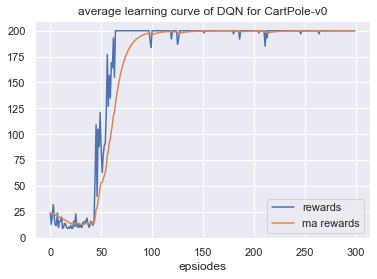

Episode:10/50, reward:197.0
Episode:20/50, reward:200.0
Episode:30/50, reward:200.0
Episode:40/50, reward:200.0
Episode:50/50, reward:200.0
结果保存完毕！


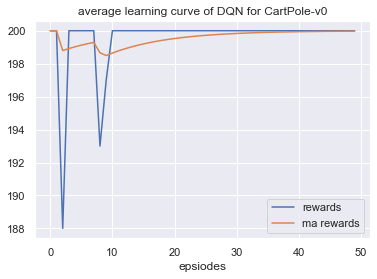

In [8]:
if __name__ == "__main__":
    cfg = DQNConfig()

    # train
    env, agent = env_agent_config(cfg, seed=1)
    rewards, ma_rewards = train(cfg, env, agent)
    make_dir(cfg.result_path, cfg.model_path)
    agent.save(path=cfg.model_path)
    save_results(rewards, ma_rewards, tag='train', path=cfg.result_path)
    plot_rewards(rewards, ma_rewards, tag="train",
                 algo=cfg.algo, path=cfg.result_path)
    # eval
    env, agent = env_agent_config(cfg, seed=10)
    agent.load(path=cfg.model_path)
    rewards, ma_rewards = eval(cfg, env, agent)
    save_results(rewards,ma_rewards, tag='eval', path=cfg.result_path)
    plot_rewards(rewards,ma_rewards, tag="eval", env=cfg.env, algo = cfg.algo, path=cfg.result_path)

In [10]:
import numpy as np

eval_rewards= np.load('./outputs/CartPole-v0/20211012-160908/results/eval_rewards.npy', encoding = "bytes")
eval_ma_rewards= np.load('./outputs/CartPole-v0/20211012-160908/results/eval_ma_rewards.npy', encoding = "bytes")

print(eval_rewards)
print(eval_ma_rewards)

[200. 200. 188. 200. 200. 200. 200. 200. 193. 197. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200.]
[200.         200.         198.8        198.92       199.028
 199.1252     199.21268    199.291412   198.6622708  198.49604372
 198.64643935 198.78179541 198.90361587 199.01325428 199.11192886
 199.20073597 199.28066237 199.35259614 199.41733652 199.47560287
 199.52804258 199.57523832 199.61771449 199.65594304 199.69034874
 199.72131387 199.74918248 199.77426423 199.79683781 199.81715403
 199.83543862 199.85189476 199.86670529 199.88003476 199.89203128
 199.90282815 199.91254534 199.9212908  199.92916172 199.93624555
 199.942621   199.9483589  199.95352301 199.95817071 199.96235364
 199.96611827 199.96950644 199.9725558  199.97530022 199.9777702 ]
